In [67]:
import math
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import os
import glob
import datetime
import copy
import random

In [2]:
# returns daily return history, list of dates, daily ewma of returns
def ewma_returns(stocks):
    dates = set()
    filenames = []
    #for filename in os.listdir("./SP500Stocks"):
    for filename in os.listdir("./Top25Stocks"):
        if len(stocks) == 0:
            if "csv" in filename:
                filenames.append(filename)
        else:
            if "csv" in filename and filename[:-4] in stocks:
                filenames.append(filename)
    #format for consolidate info is {name: {dates: {date, open}, }}
    Histories = {}
    Exp_weighted = {}
    for file in filenames:
        
        #with open("SP500Stocks/"+file, 'r') as f:
        with open("Top25Stocks/"+file, 'r') as f: 
            reader = csv.reader(f)
            next(reader)  # gets the first line
            previousClose = next(reader)[4]
            
            history = {}

            for row in reader:

                dates.add(row[0])
     
                try:
                    # daily return
                    history[row[0]] = (float(row[4])-float(previousClose))/float(previousClose)*100
                except:
                    pass
                previousClose = row[4]
                
                
            # calculate ewma of daily returns
            df = pd.DataFrame(data = history, index = ['returns']).transpose()
            exp_avg=df.ewm(span = 30, min_periods=30, ignore_na=True).mean()
            
            #isolate values and dates and zip them into dictionary
            exp_avg = exp_avg['returns'].values
            a = list(df.index)
            exp_avg_dict = {}
            exp_avg_dict = dict(zip(a,exp_avg))
            
            # remove nan entries (all values less than window size are nan)
            pop_list = []
            for key in exp_avg_dict.keys():
                if math.isnan(exp_avg_dict[key]):
                    pop_list.append(key)  
            for key in pop_list:
                exp_avg_dict.pop(key)

            
            Exp_weighted[file[:-4]] = exp_avg_dict
            
            Histories[file[:-4]] = history
            
            
            
    sortedDates = [date for date in dates]
    sortedDates = sorted(sortedDates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    return Histories, sortedDates, Exp_weighted


In [95]:
a,b,c = ewma_returns([])

In [96]:
print(b[1900])

2017-03-31


In [4]:
# same function as above except 30 day moving average instead of ewma
def ma_returns(stocks):
    dates = set()
    filenames = []
    #for filename in os.listdir("./SP500Stocks"):
    for filename in os.listdir("./Top25Stocks"):
        if len(stocks) == 0:
            if "csv" in filename:
                filenames.append(filename)
        else:
            if "csv" in filename and filename[:-4] in stocks:
                filenames.append(filename)
    #format for consolidate info is {name: {dates: {date, open}, }}
    Histories = {}
    normal_weighted = {}
    for file in filenames:
        
        #with open("SP500Stocks/"+file, 'r') as f:
        with open("Top25Stocks/"+file, 'r') as f: 
            reader = csv.reader(f)
            next(reader)  # gets the first line
            previousClose = next(reader)[4]
            
            history = {}

            for row in reader:

                dates.add(row[0])
                try:
                    # get daily returns
                    history[row[0]] = (float(row[4])-float(previousClose))/float(previousClose)*100
                except:
                    pass
                previousClose = row[4]
                
                
            # calculate moving average of daily returns
            df = pd.DataFrame(data = history, index = ['returns']).transpose()
            mov_avg=df.rolling(30, min_periods=30).mean()
            
            # get values and dates and combine into dictionary
            mov_avg = mov_avg['returns'].values
            a = list(df.index)
            mov_avg_dict = {}
            mov_avg_dict = dict(zip(a,mov_avg))
            
            # remove nan values (anything smaller than 30)
            pop_list = []  
            for key in mov_avg_dict.keys():
                if math.isnan(mov_avg_dict[key]):
                    pop_list.append(key)     
            for key in pop_list:
                mov_avg_dict.pop(key)

            
            normal_weighted[file[:-4]] = mov_avg_dict
            
            Histories[file[:-4]] = history
            
             
            
    sortedDates = [date for date in dates]
    sortedDates = sorted(sortedDates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    return Histories, sortedDates, normal_weighted

q,r,s = ma_returns([])


In [88]:
import statistics as st
# sharpe ratio
def sharpe(portfolio):
    daily_percent_return = []
    for i in range(1,len(portfolio)):
        daily_return = (portfolio[i]-portfolio[i-1])/portfolio[i-1]
        daily_percent_return.append(daily_return)
        
    stdev = st.pstdev(daily_percent_return)
    annualized_vol = math.sqrt(252) * stdev
    
    total_return = (portfolio[-1]-portfolio[0])/portfolio[0] 
    annualized_return = (1+total_return) ** (252/len(portfolio)) - 1
        
    return annualized_return/annualized_vol, annualized_return, annualized_vol

# sortino ratio
def sortino(portfolio):
    daily_percent_return = []
    for i in range(1,len(portfolio)):
        daily_return = (portfolio[i]-portfolio[i-1])/portfolio[i-1]
        daily_percent_return.append(daily_return)
        
    # sortino only cares about downside vol
    daily_negative_return = []
    for i in (daily_percent_return):
        if i < 0:
            daily_negative_return.append(i)
            
    stdev = st.pstdev(daily_negative_return)
    annualized_vol = math.sqrt(252) * stdev
    
    total_return = (portfolio[-1]-portfolio[0])/portfolio[0] 
    annualized_return = (1+total_return) ** (252/len(portfolio)) - 1
        
    return (annualized_return)/annualized_vol

In [98]:
# final returns function corrected for percentile, trade cutoffs
def highest_returns4(input_dict,input_returns,percentile, num_std_dev, mean, sigma):
    
    portfolio = 100
    portfolio_tracker = []
    
    for date in input_dict['AAPL'].keys():
        date_index = b.index(date)
        
        # backtest only on last 500 days
        if date_index > 1900:
            
            daily_returns_dict = {}
            long_trading_list = []
            short_trading_list = []
            try:
                for ticker in input_dict.keys():
                    daily_pct_return = input_dict[ticker][date]
                    daily_returns_dict[ticker] = daily_pct_return
            except:
                pass
        
            float_list = []
        
            for i in daily_returns_dict.keys():
                float_list.append(float(daily_returns_dict[i]))
            
            for i in daily_returns_dict.keys():
                
                #check percentile
                if float(daily_returns_dict[i]) >np.percentile(float_list, percentile):
                    #check cutoff
                    if float(daily_returns_dict[i]) > mean + num_std_dev*sigma:                        
                        long_trading_list.append(i)
                
                    
            
                
            trades = len(long_trading_list) + len(short_trading_list) #not shorting anymore
            
            try:
                trade_cap = portfolio/trades
            except:
                continue #if 0 trades
            
            total = 0
            try:
                date_index = b.index(date)
                new_date = b[date_index+1]
                
                # calculate daily returns
                for i in long_trading_list:
                    total += trade_cap *(1+float(input_returns[i][new_date])/100)
                for i in short_trading_list:
                    total += trade_cap *(1-float(input_returns[i][new_date])/100)
                
            except:
                pass
            portfolio_tracker.append(total)
            portfolio = total
            
    # last value is 0 by how indexing was done       
    return portfolio_tracker[:-1]

In [55]:
# same as ewma but takes in window size - used for training in other file
def ewma_returns1(stocks,window_size):
    dates = set()
    filenames = []
    #for filename in os.listdir("./SP500Stocks"):
    for filename in os.listdir("./Top25Stocks"):
        if len(stocks) == 0:
            if "csv" in filename:
                filenames.append(filename)
        else:
            if "csv" in filename and filename[:-4] in stocks:
                filenames.append(filename)
    #format for consolidate info is {name: {dates: {date, open}, }}
    Histories = {}
    Exp_weighted = {}
    for file in filenames:
        
        #with open("SP500Stocks/Filtered/"+file, 'r') as f:
        with open("Top25Stocks/"+file, 'r') as f: 
            reader = csv.reader(f)
            next(reader)  # gets the first line
            previousClose = next(reader)[4]
            
            history = {}

            for row in reader:

                dates.add(row[0])
     
                try:
                    history[row[0]] = (float(row[4])-float(previousClose))/float(previousClose)*100
                except:
                    pass
                previousClose = row[4]
                
                
                
            df = pd.DataFrame(data = history, index = ['returns']).transpose() 
            exp_avg=df.ewm(span = window_size, min_periods=window_size, ignore_na=True).mean()
            
            
            exp_avg = exp_avg['returns'].values
            a = list(df.index)
            exp_avg_dict = {}
            exp_avg_dict = dict(zip(a,exp_avg))
            
            pop_list = []
            
            for key in exp_avg_dict.keys():
                if math.isnan(exp_avg_dict[key]):
                    pop_list.append(key)
                    
            for key in pop_list:
                exp_avg_dict.pop(key)

            
            Exp_weighted[file[:-4]] = exp_avg_dict
            
            Histories[file[:-4]] = history
            
              
            
    sortedDates = [date for date in dates]
    sortedDates = sorted(sortedDates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    return Histories, sortedDates, Exp_weighted

In [97]:
#backtest on top 25 stocks
def backtest(window_size, percentile, num_std, mean, sigma):
    back_a, back_b, back_c = ewma_returns1([],window_size)
    results = highest_returns4(back_c, back_a, percentile, num_std, mean, sigma)
    return results

mean = 0.19568180057740556
sigma = 0.15384828954401814
results = backtest(30,70,0, mean, sigma)
print(results[-1])

121.04734486450528


In [89]:
a,b,c = (sharpe(results))
print(a)
print(b)
print(c)
print(sortino(results))

0.6276008344812313
0.0980962338069622
0.15630354266186977
0.7410346637482624


Text(0, 0.5, 'Profits')

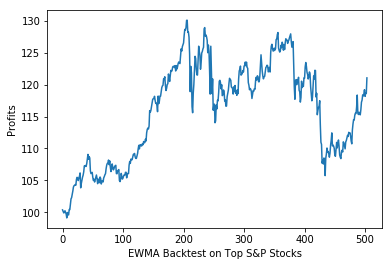

In [86]:
length = len(results)
timesteps = [j for j in range(length)]
plt.plot(timesteps, results)
plt.xlabel('EWMA Backtest on Top S&P Stocks')
plt.ylabel('Profits')

In [58]:
#backtest simple moving average strategy
def backtest(percentile, num_std, mean, sigma):
    back_a, back_b, back_c = ma_returns([])
    results = highest_returns4(back_c, back_a, percentile, num_std, mean, sigma)
    return results

mean = 0.19568180057740556
sigma = 0.15384828954401814
results = backtest(80,0, mean, sigma)
print(results[-1])

111.78900303661307


In [62]:
print(sharpe(results))
print(sortino(results))

0.36426625906588916
0.45366571510656833


Text(0, 0.5, 'Profits')

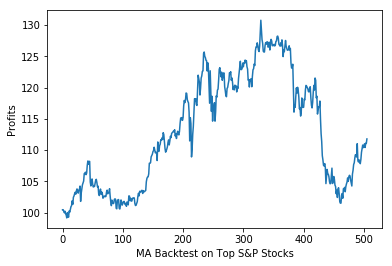

In [60]:
length = len(results)
timesteps = [j for j in range(length)]
plt.plot(timesteps, results)
plt.xlabel('MA Backtest on Top S&P Stocks')
plt.ylabel('Profits')

In [64]:
# returns daily return history, list of dates, daily ewma of returns
def ewma_returns_sp(stocks):
    dates = set()
    filenames = []
    for filename in os.listdir("./SP500Stocks"):
    #for filename in os.listdir("./Top25Stocks"):
        if len(stocks) == 0:
            if "csv" in filename:
                filenames.append(filename)
        else:
            if "csv" in filename and filename[:-4] in stocks:
                filenames.append(filename)
    #format for consolidate info is {name: {dates: {date, open}, }}
    Histories = {}
    Exp_weighted = {}
    for file in filenames:
        
        with open("SP500Stocks/"+file, 'r') as f:
        #with open("Top25Stocks/"+file, 'r') as f: 
            reader = csv.reader(f)
            next(reader)  # gets the first line
            previousClose = next(reader)[4]
            
            history = {}

            for row in reader:

                dates.add(row[0])
     
                try:
                    # daily return
                    history[row[0]] = (float(row[4])-float(previousClose))/float(previousClose)*100
                except:
                    pass
                previousClose = row[4]
                
                
            # calculate ewma of daily returns
            df = pd.DataFrame(data = history, index = ['returns']).transpose()
            exp_avg=df.ewm(span = 30, min_periods=30, ignore_na=True).mean()
            
            #isolate values and dates and zip them into dictionary
            exp_avg = exp_avg['returns'].values
            a = list(df.index)
            exp_avg_dict = {}
            exp_avg_dict = dict(zip(a,exp_avg))
            
            # remove nan entries (all values less than window size are nan)
            pop_list = []
            for key in exp_avg_dict.keys():
                if math.isnan(exp_avg_dict[key]):
                    pop_list.append(key)  
            for key in pop_list:
                exp_avg_dict.pop(key)

            
            Exp_weighted[file[:-4]] = exp_avg_dict
            
            Histories[file[:-4]] = history
            
            
            
    sortedDates = [date for date in dates]
    sortedDates = sorted(sortedDates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    return Histories, sortedDates, Exp_weighted


In [65]:
sp_history, sp_dates, sp_ewma = ewma_returns_sp([])

In [74]:
#backtest on all stocks
def backtest1(sp_history, sp_dates, sp_ewma, window_size, percentile, num_std, mean, sigma):
    
    results = highest_returns4(sp_ewma, sp_history, percentile, num_std, mean, sigma)
    return results

mean = 0.19568180057740556
sigma = 0.15384828954401814
results = backtest1(sp_history, sp_dates, sp_ewma, 30,80,1, mean, sigma)
print(results[-1])

60.40906817733316


In [76]:
keys = random.sample(list(sp_ewma.keys()), 25)
ewma_sample = {key: sp_ewma[key] for key in keys}
return_sample = {key: sp_history[key] for key in keys}
print(keys)

['NOV', 'AWK', 'VRTX', 'MSFT', 'TMO', 'HBAN', 'NOC', 'STT', 'CMCSA', 'HES', 'TPR', 'MDT', 'BHGE', 'FRT', 'UHS', 'FFIV', 'K', 'PEP', 'MSI', 'PKI', 'ADBE', 'AEP', 'MCO', 'WMT', 'VLO']


In [79]:
# backtest on randoms
def backtest2(return_sample, sp_dates, ewma_sample, window_size, percentile, num_std, mean, sigma):
    
    results = highest_returns4(ewma_sample, return_sample, percentile, num_std, mean, sigma)
    return results

mean = 0.19568180057740556
sigma = 0.15384828954401814
results = backtest1(return_sample, sp_dates, ewma_sample, 30,80,0, mean, sigma)
print(results[-1])

100.95530111113152


In [105]:
#backtest on whole SP 
def backtest(sp_history, sp_dates, sp_ewma,window_size, percentile, num_std, mean, sigma):
    #back_a, back_b, back_c = ewma_returns1([],window_size)
    results = highest_returns4(sp_ewma, sp_history, percentile, num_std, mean, sigma)
    return results

mean = 0.19568180057740556
sigma = 0.15384828954401814
results = backtest(sp_history, sp_dates, sp_ewma,30,95,0, 0, sigma)
print(results[-1])

95.35734616704605


Text(0, 0.5, 'Profits')

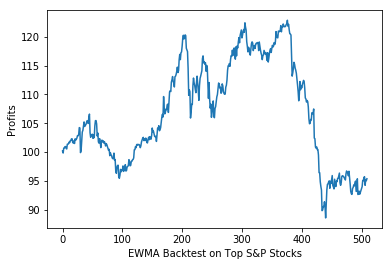

In [106]:
length = len(results)
timesteps = [j for j in range(length)]
plt.plot(timesteps, results)
plt.xlabel('EWMA Backtest on Top S&P Stocks')
plt.ylabel('Profits')